## Imports

In [22]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import Input, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import BinaryCrossentropy
from pyMLaux import show_img_data, plot_history, evaluate_regression_result

import tensorflow_hub as hub

## Load Data

In [2]:
pizza_dir = './data/input/pizza_not_pizza/pizza' 
not_pizza_dir = './data/input/pizza_not_pizza/not_pizza'
data_dir = './data/input/pizza_not_pizza'
test_dir = './data/input/pizza_not_pizza_test'
pizza_test_dir = './data/input/pizza_not_pizza_test/pizza'
not_pizza_test_dir = './data/input/pizza_not_pizza_test/not_pizza'

AI_pizza_dir = r'C:\Users\jakob\Desktop\COV-AI\pizza_not_pizza\pizza' 
AI_not_pizza_dir = r'C:\Users\jakob\Desktop\COV-AI\pizza_not_pizza\not_pizza'
AI_data_dir = r'C:\Users\jakob\Desktop\COV-AI\pizza_not_pizza'


Augmented_AI_pizza_dir = r'C:\Users\jakob\Desktop\COV-AI\augmented_pizza_not_pizza\pizza' 
Augmented_AI_not_pizza_dir = r'C:\Users\jakob\Desktop\COV-AI\augmented_pizza_not_pizza\not_pizza'
Augmented_AI_data_dir = r'C:\Users\jakob\Desktop\COV-AI\augmented_pizza_not_pizza'



In [3]:
num_pizza_images = len(os.listdir(pizza_dir))
num_non_pizza_images = len(os.listdir(not_pizza_dir))
num_test_pizza = len(os.listdir(pizza_test_dir))
num_test_non_pizza = len(os.listdir(not_pizza_test_dir))

print(f'Number of Pizza images: {num_pizza_images}')
print(f'Number of Non-Pizza images: {num_non_pizza_images}')
print(f'Number of Pizza test images: {num_test_pizza}')
print(f'Number of Non-Pizza test images: {num_test_non_pizza}')



Number of Pizza images: 833
Number of Non-Pizza images: 833
Number of Pizza test images: 150
Number of Non-Pizza test images: 150


# Original Data

## Train/Validation/Test Data Sets

In [16]:
batch_size = 300

data_gen = ImageDataGenerator(rescale = 1/255., validation_split = 0.2)

train_data = data_gen.flow_from_directory(data_dir, 
                                          target_size = (224, 224), 
                                          batch_size = batch_size,
                                          subset = 'training',
                                          class_mode = 'binary',seed = 42)
val_data = data_gen.flow_from_directory(data_dir, 
                                        target_size = (224, 224), 
                                        batch_size = batch_size,
                                        subset = 'validation',
                                        class_mode = 'binary',seed = 42)

test_data = data_gen.flow_from_directory(test_dir, 
                                         target_size = (224, 224), 
                                         batch_size = batch_size,
                                         class_mode = 'binary', seed = 42)

Found 1334 images belonging to 2 classes.
Found 332 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


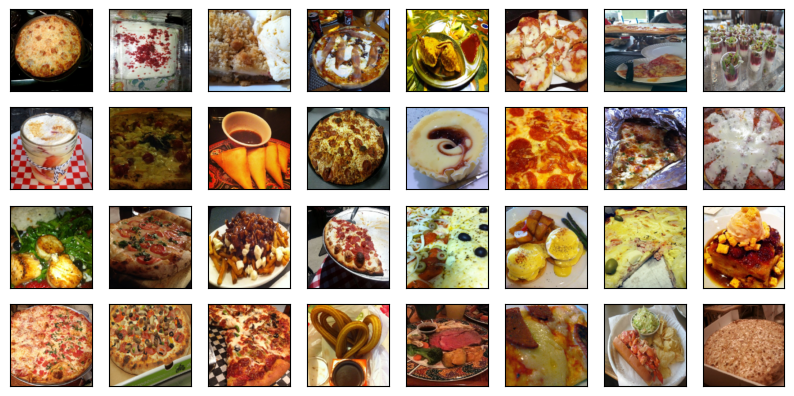

In [6]:
for image_batch, label_batch in train_data:
    show_img_data(image_batch, no=batch_size, layout=(8, 8), figsize=(10, 10))
    
    break



## Baseline Model

In [22]:

model_1 = Sequential([
    Input(shape = (224, 224, 3)), # Input layer    
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'), # First Convolutional layer
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'), # Second Convolutional layer
    Flatten(),
    Dense(1, activation = 'sigmoid') # Output layer  
])

model_1.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(),
                metrics = ['accuracy'])



## Train Model

In [23]:
model_filepath = './data/cnn_models/pizza-not-pizza_cnn1.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max', save_weights_only=False)
callbacks_list = [checkpoint]

history_1 = model_1.fit(train_data,
                        epochs= 5,
                        steps_per_epoch = len(train_data),
                        validation_data = val_data,
                        validation_steps = len(val_data),
                        callbacks=callbacks_list)



Epoch 1/5
46/46 [==============================] - ETA: 0s - loss: 1.8408 - accuracy: 0.5956
Epoch 1: val_accuracy improved from -inf to 0.70166, saving model to ./data/cnn_models\pizza-not-pizza_cnn1.hdf5
46/46 [==============================] - 35s 730ms/step - loss: 1.8408 - accuracy: 0.5956 - val_loss: 0.6107 - val_accuracy: 0.7017
Epoch 2/5
46/46 [==============================] - ETA: 0s - loss: 0.5231 - accuracy: 0.7572
Epoch 2: val_accuracy improved from 0.70166 to 0.71547, saving model to ./data/cnn_models\pizza-not-pizza_cnn1.hdf5
46/46 [==============================] - 32s 704ms/step - loss: 0.5231 - accuracy: 0.7572 - val_loss: 0.5609 - val_accuracy: 0.7155
Epoch 3/5
46/46 [==============================] - ETA: 0s - loss: 0.3135 - accuracy: 0.8796
Epoch 3: val_accuracy did not improve from 0.71547
46/46 [==============================] - 32s 692ms/step - loss: 0.3135 - accuracy: 0.8796 - val_loss: 0.6985 - val_accuracy: 0.6823
Epoch 4/5
46/46 [============================

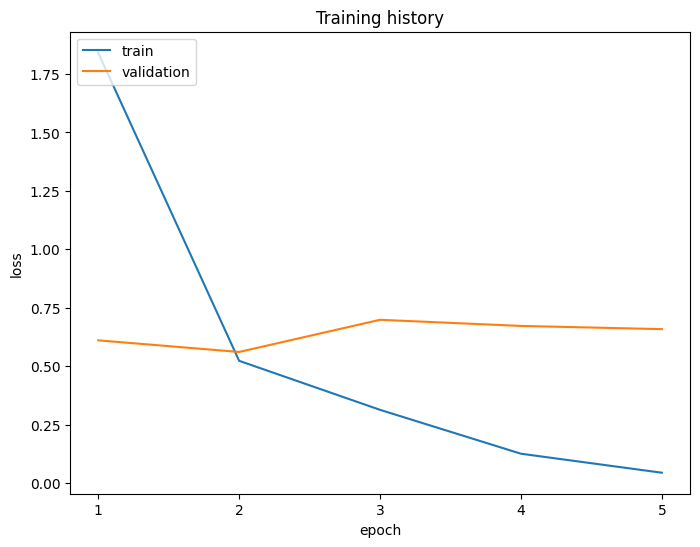

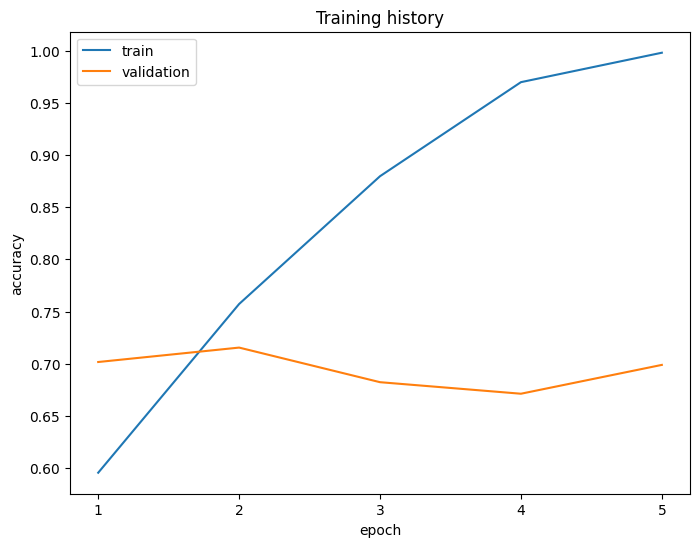

In [24]:
plot_history(history_1)

In [25]:
# Evaluate the model on the test data

model = tf.keras.models.load_model(model_filepath)

test_loss, test_acc = model.evaluate(test_data)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")

5/5 [==============================] - 2s 363ms/step - loss: 0.5412 - accuracy: 0.6933
Test loss: 0.5412288904190063
Test accuracy: 0.6933333277702332


## Improving the Model


    Increasing the number of epochs
    Adding Max Pooling Layer
    Adding more convolutional layers
    Changing the number of filters
    Changing the size of our filters
    Changing the pool size of Max Pooling layer



In [30]:
model_2 = Sequential([
    Input(shape = (224, 224, 3)),
    Conv2D(filters = 10, kernel_size = 2, padding = 'valid', activation = 'relu'),
    MaxPool2D(pool_size = 2),
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'),
    MaxPool2D(pool_size = 2),
    Conv2D(filters = 64, kernel_size = 2, padding = 'valid', activation = 'relu'),
    MaxPool2D(pool_size = 2),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])

model_2.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(learning_rate = 0.0001),
                metrics = ['accuracy'])



In [38]:
model_filepath = './data/cnn_models/pizza-not-pizza_cnn2.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max', save_weights_only=False)
callbacks_list = [checkpoint]

history_2 = model_2.fit(train_data,
                        epochs= 20,
                        steps_per_epoch = len(train_data),
                        validation_data = val_data,
                        validation_steps = len(val_data),
                        callbacks=callbacks_list)

Epoch 1/20
42/42 [==============================] - ETA: 0s - loss: 0.6791 - accuracy: 0.5652
Epoch 1: val_accuracy improved from -inf to 0.66566, saving model to ./data/cnn_models\pizza-not-pizza_cnn2.hdf5
42/42 [==============================] - 21s 487ms/step - loss: 0.6791 - accuracy: 0.5652 - val_loss: 0.6509 - val_accuracy: 0.6657
Epoch 2/20
42/42 [==============================] - ETA: 0s - loss: 0.6437 - accuracy: 0.6244
Epoch 2: val_accuracy improved from 0.66566 to 0.69578, saving model to ./data/cnn_models\pizza-not-pizza_cnn2.hdf5
42/42 [==============================] - 10s 237ms/step - loss: 0.6437 - accuracy: 0.6244 - val_loss: 0.6151 - val_accuracy: 0.6958
Epoch 3/20
42/42 [==============================] - ETA: 0s - loss: 0.6044 - accuracy: 0.6979
Epoch 3: val_accuracy improved from 0.69578 to 0.70783, saving model to ./data/cnn_models\pizza-not-pizza_cnn2.hdf5
42/42 [==============================] - 10s 227ms/step - loss: 0.6044 - accuracy: 0.6979 - val_loss: 0.5911 

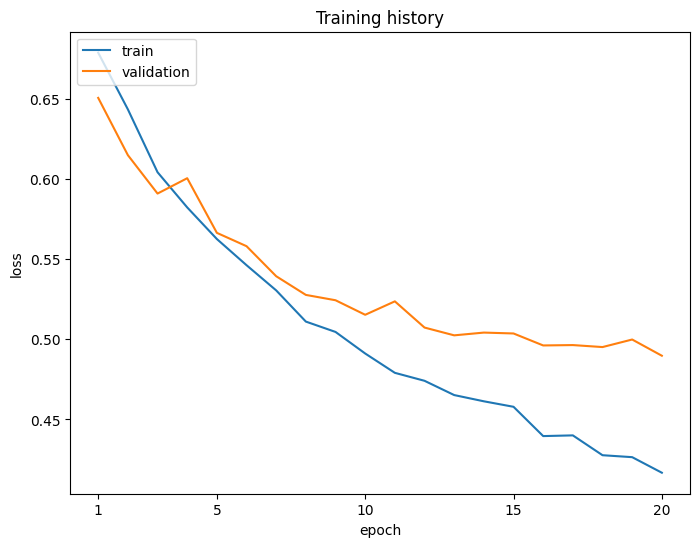

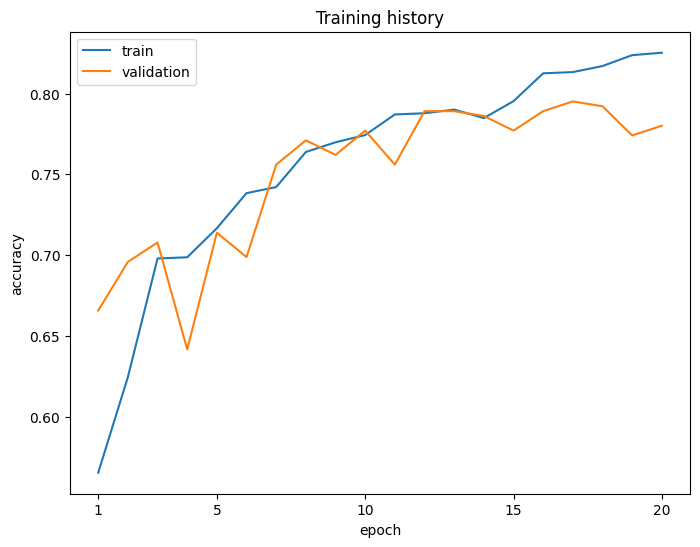

In [39]:
plot_history(history_2)

In [41]:
# Evaluate the model on the test data


model = tf.keras.models.load_model(model_filepath)


test_loss, test_acc = model.evaluate(test_data)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")



1/1 [==============================] - 2s 2s/step - loss: 0.3408 - accuracy: 0.8433
Test loss: 0.3408184349536896
Test accuracy: 0.8433333039283752


# AI Data

## AI Data Train/Validation Data Sets

In [43]:
AI_num_pizza_images = len(os.listdir(AI_pizza_dir))
AI_non_pizza_images = len(os.listdir(AI_not_pizza_dir))
print(f'Number of Generated Pizza images: {AI_num_pizza_images}')
print(f'Number of Generated Non-Pizza images: {AI_non_pizza_images}')

Number of Generated Pizza images: 1317
Number of Generated Non-Pizza images: 1306


In [44]:
batch_size = 32

data_gen = ImageDataGenerator(rescale = 1/255., validation_split = 0.2)

AI_train_data = data_gen.flow_from_directory(AI_data_dir, 
                                          target_size = (224, 224), 
                                          batch_size = batch_size,
                                          subset = 'training',
                                          class_mode = 'binary')
AI_val_data = data_gen.flow_from_directory(AI_data_dir, 
                                        target_size = (224, 224), 
                                        batch_size = batch_size,
                                        subset = 'validation',
                                        class_mode = 'binary')


Found 2099 images belonging to 2 classes.
Found 524 images belonging to 2 classes.


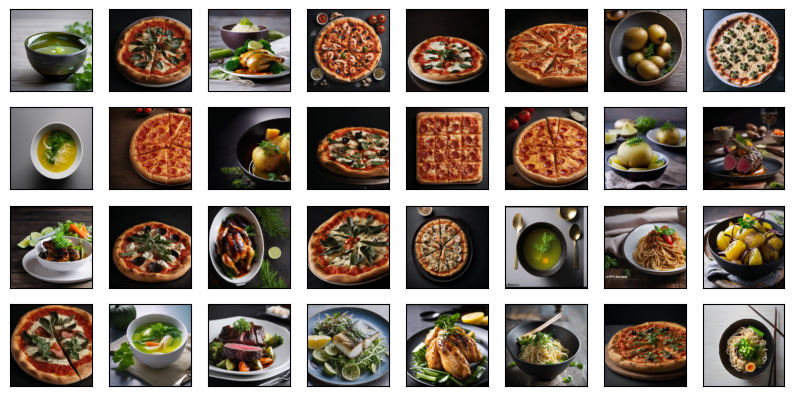

In [45]:
for image_batch, label_batch in AI_train_data:
    show_img_data(image_batch, no=batch_size, layout=(8, 8), figsize=(10, 10))
    
    break



In [28]:
model_filepath = './data/cnn_models/pizza-not-pizza_cnn_AI.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max', save_weights_only=False)

callbacks_list = [checkpoint]


history = model_1.fit(AI_train_data, # using generated data
                        epochs= 5,
                        steps_per_epoch = len(AI_train_data),
                        validation_data = AI_val_data,
                        validation_steps = len(AI_val_data),
                        callbacks=callbacks_list)

Epoch 1/5
52/52 [==============================] - ETA: 0s - loss: 0.0450 - accuracy: 0.9799
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to ./data/cnn_models\pizza-not-pizza_cnn_AI.hdf5
52/52 [==============================] - 130s 3s/step - loss: 0.0450 - accuracy: 0.9799 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 2/5
52/52 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
52/52 [==============================] - 100s 2s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0047 - val_accuracy: 0.9976
Epoch 3/5
52/52 [==============================] - ETA: 0s - loss: 3.1103e-04 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
52/52 [==============================] - 99s 2s/step - loss: 3.1103e-04 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 0.9976
Epoch 4/5
52/52 [==============================] - ETA: 0s - loss: 2.0201e-04 - accuracy: 1.0000
Epoch 4: v

In [30]:
# Evaluate the model on the test data
model_filepath = './data/cnn_models/pizza-not-pizza_cnn_AI.hdf5'

model = tf.keras.models.load_model(model_filepath)

test_loss, test_acc = model.evaluate(test_data)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")

5/5 [==============================] - 1s 221ms/step - loss: 3.4305 - accuracy: 0.5733
Test loss: 3.4305384159088135
Test accuracy: 0.5733333230018616


In [46]:
model_filepath = './data/cnn_models/pizza-not-pizza_cnn_AI.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max', save_weights_only=False)

callbacks_list = [checkpoint]


history_3 = model_2.fit(AI_train_data, # using generated data
                        epochs= 20,
                        steps_per_epoch = len(AI_train_data),
                        validation_data = AI_val_data,
                        validation_steps = len(AI_val_data),
                        callbacks=callbacks_list)

Epoch 1/20
66/66 [==============================] - ETA: 0s - loss: 0.1547 - accuracy: 0.9576
Epoch 1: val_accuracy improved from -inf to 0.91603, saving model to ./data/cnn_models\pizza-not-pizza_cnn_AI.hdf5
66/66 [==============================] - 118s 2s/step - loss: 0.1547 - accuracy: 0.9576 - val_loss: 0.2183 - val_accuracy: 0.9160
Epoch 2/20
66/66 [==============================] - ETA: 0s - loss: 0.0816 - accuracy: 0.9800
Epoch 2: val_accuracy did not improve from 0.91603
66/66 [==============================] - 111s 2s/step - loss: 0.0816 - accuracy: 0.9800 - val_loss: 0.2143 - val_accuracy: 0.9160
Epoch 3/20
66/66 [==============================] - ETA: 0s - loss: 0.0605 - accuracy: 0.9871
Epoch 3: val_accuracy improved from 0.91603 to 0.92939, saving model to ./data/cnn_models\pizza-not-pizza_cnn_AI.hdf5
66/66 [==============================] - 110s 2s/step - loss: 0.0605 - accuracy: 0.9871 - val_loss: 0.1581 - val_accuracy: 0.9294
Epoch 4/20
66/66 [==========================

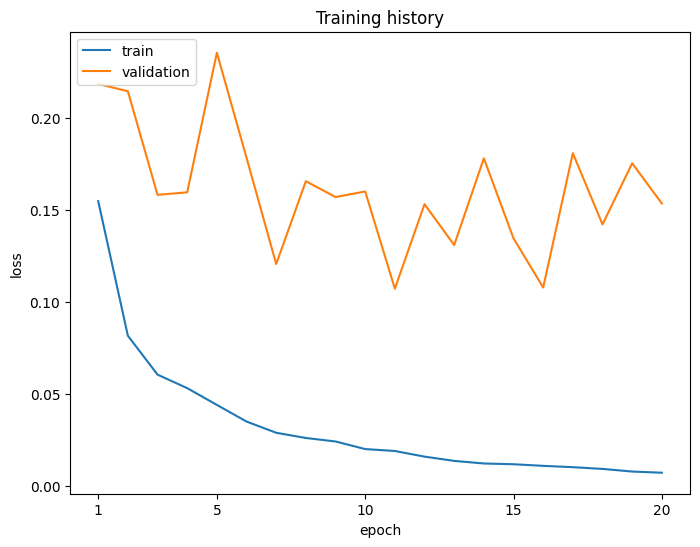

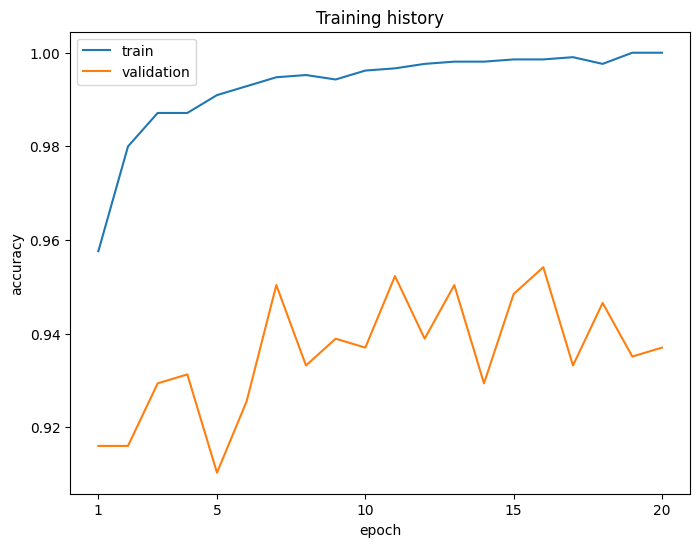

In [47]:
plot_history(history_3)

In [42]:
# Evaluate the model on the test data
model_filepath = './data/cnn_models/pizza-not-pizza_cnn_AI.hdf5'

model = tf.keras.models.load_model(model_filepath)

test_loss, test_acc = model.evaluate(test_data)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")



1/1 [==============================] - 2s 2s/step - loss: 1.1084 - accuracy: 0.7367
Test loss: 1.1084260940551758
Test accuracy: 0.7366666793823242


### Dropout und L2 Regularisierung

In [13]:
model_3 = Sequential([
    Input(shape = (224, 224, 3)),
    Conv2D(filters = 10, kernel_size = 2, padding = 'same', activation = 'relu', kernel_regularizer = l2(0.001)),
    MaxPool2D(pool_size = 2),
    Dropout(0.2),
    Conv2D(filters = 32, kernel_size = 2, padding = 'same', activation = 'relu', kernel_regularizer = l2(0.001)),
    MaxPool2D(pool_size = 2),
    Dropout(0.2),
    Conv2D(filters = 64, kernel_size = 2, padding = 'same', activation = 'relu', kernel_regularizer = l2(0.001)),
    MaxPool2D(pool_size = 2),
    Dropout(0.2),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])

model_3.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(learning_rate = 0.0001),
                metrics = ['accuracy'])

In [52]:
model_filepath = './data/cnn_models/pizza-not-pizza_cnn_AI_dropout_l2.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max', save_weights_only=False)

callbacks_list = [checkpoint]

history_4 = model_3.fit(AI_train_data, # using generated data
                        epochs= 20,
                        steps_per_epoch = len(AI_train_data),
                        validation_data = AI_val_data,
                        validation_steps = len(AI_val_data),
                        callbacks=callbacks_list)

Epoch 1/20
66/66 [==============================] - ETA: 0s - loss: 0.5770 - accuracy: 0.7956
Epoch 1: val_accuracy improved from -inf to 0.81679, saving model to ./data/cnn_models\pizza-not-pizza_cnn_AI_dropout_l2.hdf5
66/66 [==============================] - 114s 2s/step - loss: 0.5770 - accuracy: 0.7956 - val_loss: 0.5369 - val_accuracy: 0.8168
Epoch 2/20
66/66 [==============================] - ETA: 0s - loss: 0.3461 - accuracy: 0.8795
Epoch 2: val_accuracy improved from 0.81679 to 0.87595, saving model to ./data/cnn_models\pizza-not-pizza_cnn_AI_dropout_l2.hdf5
66/66 [==============================] - 113s 2s/step - loss: 0.3461 - accuracy: 0.8795 - val_loss: 0.3849 - val_accuracy: 0.8760
Epoch 3/20
66/66 [==============================] - ETA: 0s - loss: 0.2395 - accuracy: 0.9295
Epoch 3: val_accuracy improved from 0.87595 to 0.94466, saving model to ./data/cnn_models\pizza-not-pizza_cnn_AI_dropout_l2.hdf5
66/66 [==============================] - 107s 2s/step - loss: 0.2395 - acc

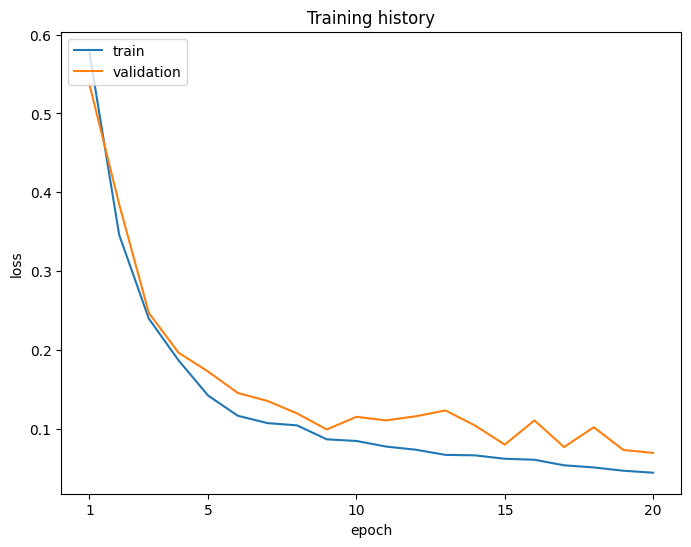

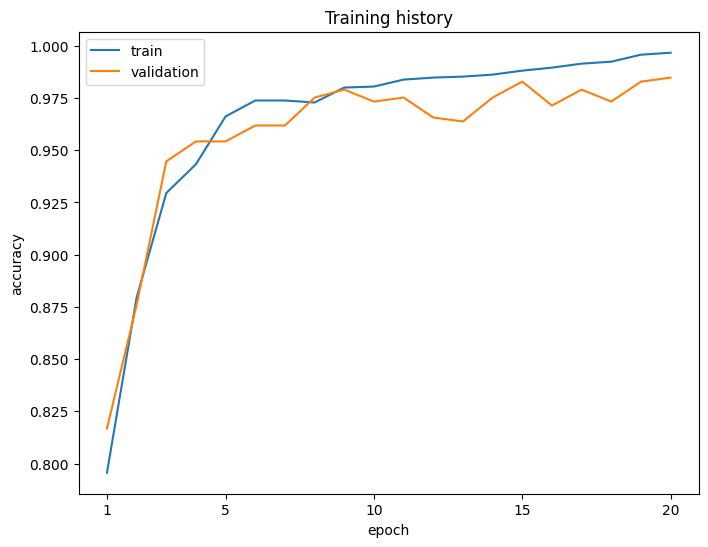

In [53]:
plot_history(history_4)

In [54]:
# Evaluate the model on the test data

model = tf.keras.models.load_model(model_filepath)

test_loss, test_acc = model.evaluate(test_data)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")

10/10 [==============================] - 2s 210ms/step - loss: 2.3543 - accuracy: 0.5533
Test loss: 2.3543200492858887
Test accuracy: 0.5533333420753479


# Augmented AI Data

## Augmented AI Data Train/Validation Data Sets

In [55]:
AI_num_pizza_images = len(os.listdir(Augmented_AI_pizza_dir))
AI_non_pizza_images = len(os.listdir(Augmented_AI_not_pizza_dir))
print(f'Number of Generated Pizza images: {AI_num_pizza_images}')
print(f'Number of Generated Non-Pizza images: {AI_non_pizza_images}')


Number of Generated Pizza images: 1039
Number of Generated Non-Pizza images: 1007


In [56]:
Augmented_AI_pizza_dir = r'C:\Users\jakob\Desktop\COV-AI\augmented_pizza_not_pizza\pizza' 
Augmented_AI_not_pizza_dir = r'C:\Users\jakob\Desktop\COV-AI\augmented_pizza_not_pizza\not_pizza'
Augmented_AI_data_dir = r'C:\Users\jakob\Desktop\COV-AI\augmented_pizza_not_pizza'


In [57]:
batch_size = 32

data_gen = ImageDataGenerator(rescale = 1/255., validation_split = 0.2)

augmented_AI_train_data = data_gen.flow_from_directory(Augmented_AI_data_dir, 
                                          target_size = (224, 224), 
                                          batch_size = batch_size,
                                          subset = 'training',
                                          class_mode = 'binary')
augmented_AI_val_data = data_gen.flow_from_directory(Augmented_AI_data_dir, 
                                        target_size = (224, 224), 
                                        batch_size = batch_size,
                                        subset = 'validation',
                                        class_mode = 'binary')


Found 1638 images belonging to 2 classes.
Found 408 images belonging to 2 classes.


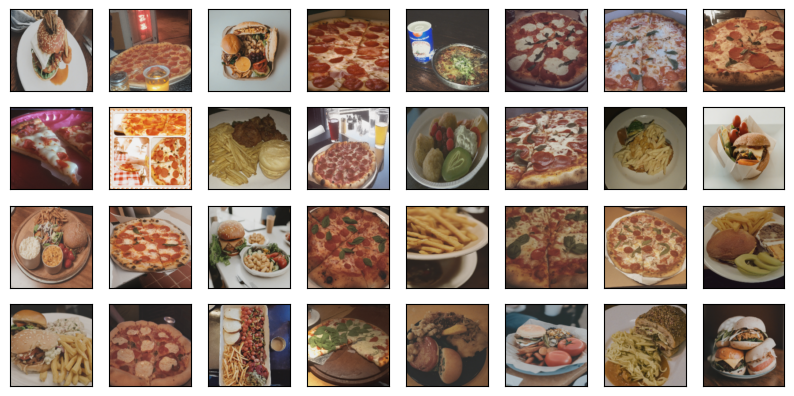

In [13]:
for image_batch, label_batch in augmented_AI_train_data:
    show_img_data(image_batch, no=batch_size, layout=(8, 8), figsize=(10, 10))
    
    break



## model 2

In [58]:
model_filepath = './data/cnn_models/pizza-not-pizza_cnn_augmented_AI.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max', save_weights_only=False)

callbacks_list = [checkpoint]


history_7 = model_2.fit(augmented_AI_train_data, # using generated data
                        epochs= 20,
                        steps_per_epoch = len(augmented_AI_train_data),
                        validation_data = augmented_AI_val_data,
                        validation_steps = len(augmented_AI_val_data),
                        callbacks=callbacks_list)

Epoch 1/20
52/52 [==============================] - ETA: 0s - loss: 0.6282 - accuracy: 0.7509
Epoch 1: val_accuracy improved from -inf to 0.81618, saving model to ./data/cnn_models\pizza-not-pizza_cnn_augmented_AI.hdf5
52/52 [==============================] - 102s 2s/step - loss: 0.6282 - accuracy: 0.7509 - val_loss: 0.4073 - val_accuracy: 0.8162
Epoch 2/20
52/52 [==============================] - ETA: 0s - loss: 0.4320 - accuracy: 0.8065
Epoch 2: val_accuracy improved from 0.81618 to 0.83088, saving model to ./data/cnn_models\pizza-not-pizza_cnn_augmented_AI.hdf5
52/52 [==============================] - 74s 1s/step - loss: 0.4320 - accuracy: 0.8065 - val_loss: 0.3720 - val_accuracy: 0.8309
Epoch 3/20
52/52 [==============================] - ETA: 0s - loss: 0.4203 - accuracy: 0.8077
Epoch 3: val_accuracy improved from 0.83088 to 0.83578, saving model to ./data/cnn_models\pizza-not-pizza_cnn_augmented_AI.hdf5
52/52 [==============================] - 74s 1s/step - loss: 0.4203 - accuracy

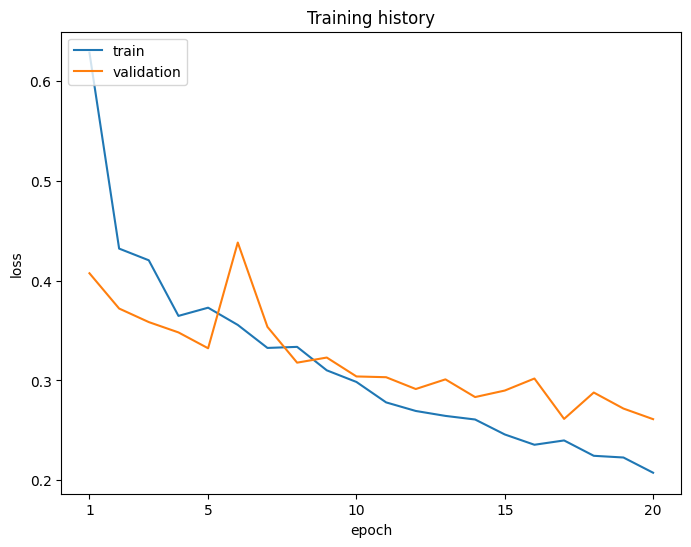

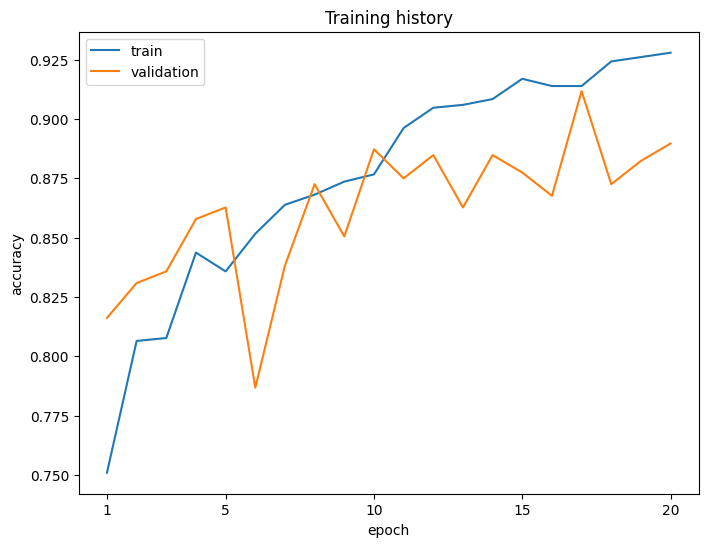

In [59]:
plot_history(history_7)

In [60]:
# Evaluate the model on the test data

model = tf.keras.models.load_model(model_filepath)

test_loss, test_acc = model.evaluate(test_data)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")

10/10 [==============================] - 2s 209ms/step - loss: 1.2114 - accuracy: 0.6400
Test loss: 1.2114206552505493
Test accuracy: 0.6399999856948853


## model 2 + Dropout + L2

In [ ]:
model_filepath = './data/cnn_models/pizza-not-pizza_cnn_Improved_AI_dropout_l2.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max', save_weights_only=False)

callbacks_list = [checkpoint]

history_8 = model_3.fit(augmented_AI_train_data, # using generated data
                        epochs= 20,
                        steps_per_epoch = len(augmented_AI_train_data),
                        validation_data = augmented_AI_val_data,
                        validation_steps = len(augmented_AI_val_data),
                        callbacks=callbacks_list)

In [ ]:
plot_history(history_8)

In [ ]:
# Evaluate the model on the test data

model = tf.keras.models.load_model(model_filepath)

test_loss, test_acc = model.evaluate(test_data)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")

# Pretrained Model

In [15]:
base_model = MobileNetV2(weights = "imagenet", include_top = False, input_shape = (224, 224, 3))

base_model.trainable = False

In [16]:
flat = tf.keras.layers.GlobalAveragePooling2D()(base_model.layers[-1].output)
dense = tf.keras.layers.Dense(256, activation='relu')(flat)
dropout = tf.keras.layers.Dropout(0.5)(dense)
output = tf.keras.layers.Dense(1, activation=None)(dropout)

model_4 = tf.keras.models.Model(inputs=base_model.inputs, outputs=output)

model_4.compile(loss = BinaryCrossentropy(),
              optimizer = Adam(learning_rate = 0.0001),
              metrics = ["accuracy"])

### Original Data

In [7]:
model_filepath = './data/cnn_models/pizza-not-pizza_cnn_imagenet.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max', save_weights_only=False)

callbacks_list = [checkpoint]

history_5 = model_4.fit(train_data, # using generated data
                        epochs= 20,
                        steps_per_epoch = len(train_data),
                        validation_data = val_data,
                        validation_steps = len(val_data),
                        callbacks=callbacks_list)

Epoch 1/20


42/42 [==============================] - ETA: 0s - loss: 5.6085 - accuracy: 0.5375
Epoch 1: val_accuracy improved from -inf to 0.78012, saving model to ./data/cnn_models\pizza-not-pizza_cnn_imagenet.hdf5
42/42 [==============================] - 24s 479ms/step - loss: 5.6085 - accuracy: 0.5375 - val_loss: 1.2896 - val_accuracy: 0.7801
Epoch 2/20
42/42 [==============================] - ETA: 0s - loss: 1.7418 - accuracy: 0.8021
Epoch 2: val_accuracy improved from 0.78012 to 0.90060, saving model to ./data/cnn_models\pizza-not-pizza_cnn_imagenet.hdf5
42/42 [==============================] - 19s 455ms/step - loss: 1.7418 - accuracy: 0.8021 - val_loss: 0.8381 - val_accuracy: 0.9006
Epoch 3/20
42/42 [==============================] - ETA: 0s - loss: 1.2328 - accuracy: 0.8673
Epoch 3: val_accuracy improved from 0.90060 to 0.91867, saving model to ./data/cnn_models\pizza-not-pizza_cnn_imagenet.hdf5
42/42 [==============================] - 22s 511ms/step - loss: 1.2328 - accuracy: 

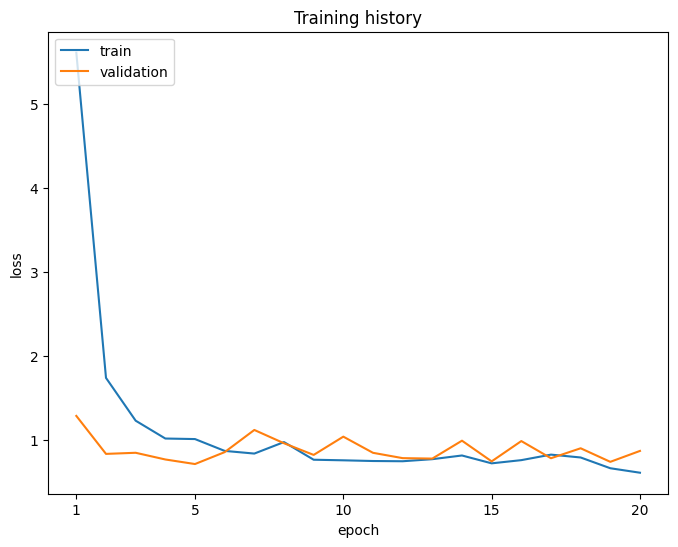

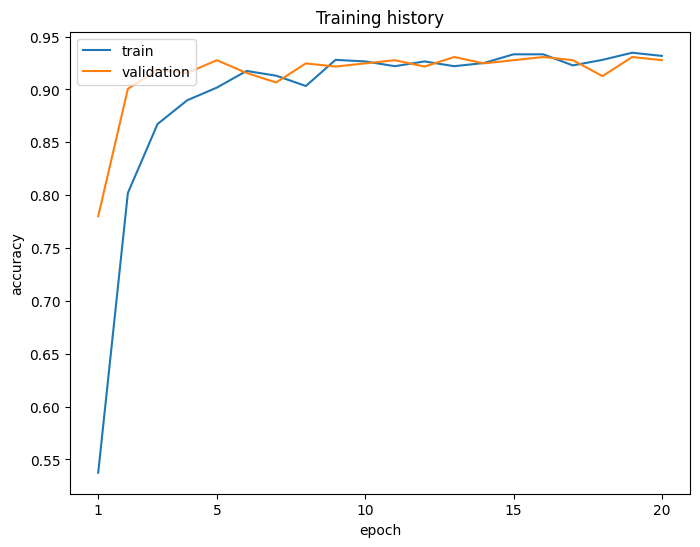

In [8]:
plot_history(history_5)

In [9]:
# Evaluate the model on the test data

model = tf.keras.models.load_model(model_filepath)

test_loss, test_acc = model.evaluate(test_data)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")

10/10 [==============================] - 5s 403ms/step - loss: 0.4885 - accuracy: 0.9533
Test loss: 0.4884902834892273
Test accuracy: 0.95333331823349


### AI Data

In [63]:
model_filepath = './data/cnn_models/pizza-not-pizza_cnn_imagenet_AI.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max', save_weights_only=False)

callbacks_list = [checkpoint]

history_6 = model_4.fit(AI_train_data, # using generated data
                        epochs= 20,
                        steps_per_epoch = len(AI_train_data),
                        validation_data = AI_val_data,
                        validation_steps = len(AI_val_data),
                        callbacks=callbacks_list)

Epoch 1/20
66/66 [==============================] - ETA: 0s - loss: 0.6234 - accuracy: 0.9319
Epoch 1: val_accuracy improved from -inf to 0.99237, saving model to ./data/cnn_models\pizza-not-pizza_cnn_imagenet_AI.hdf5
66/66 [==============================] - 134s 2s/step - loss: 0.6234 - accuracy: 0.9319 - val_loss: 0.0151 - val_accuracy: 0.9924
Epoch 2/20
66/66 [==============================] - ETA: 0s - loss: 0.0549 - accuracy: 0.9919
Epoch 2: val_accuracy improved from 0.99237 to 0.99427, saving model to ./data/cnn_models\pizza-not-pizza_cnn_imagenet_AI.hdf5
66/66 [==============================] - 121s 2s/step - loss: 0.0549 - accuracy: 0.9919 - val_loss: 0.0116 - val_accuracy: 0.9943
Epoch 3/20
66/66 [==============================] - ETA: 0s - loss: 0.0349 - accuracy: 0.9948
Epoch 3: val_accuracy improved from 0.99427 to 0.99809, saving model to ./data/cnn_models\pizza-not-pizza_cnn_imagenet_AI.hdf5
66/66 [==============================] - 124s 2s/step - loss: 0.0349 - accuracy:

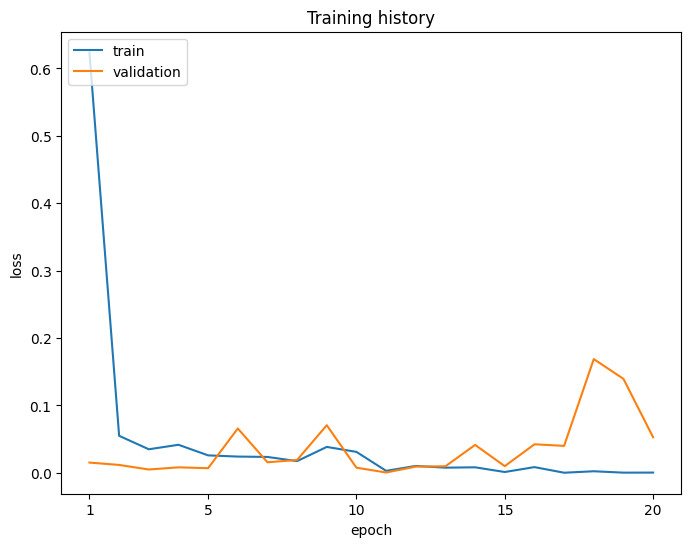

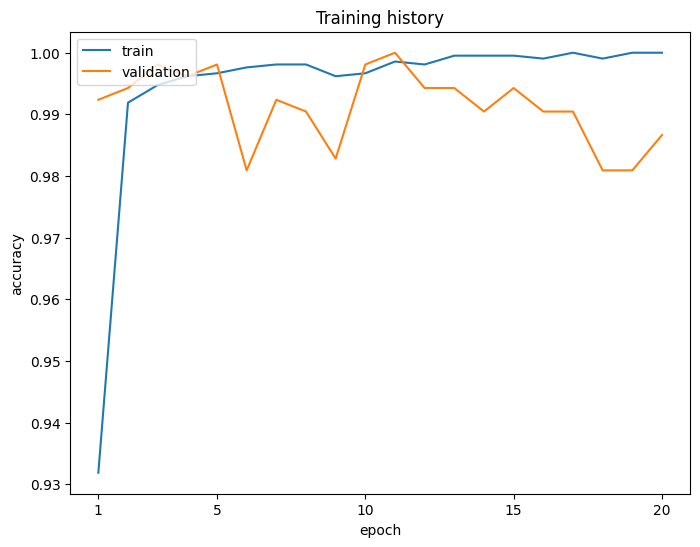

In [64]:
plot_history(history_6)

In [65]:
# Evaluate the model on the test data

model = tf.keras.models.load_model(model_filepath)

test_loss, test_acc = model.evaluate(test_data)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")

10/10 [==============================] - 5s 417ms/step - loss: 0.6855 - accuracy: 0.9267
Test loss: 0.6855489611625671
Test accuracy: 0.9266666769981384
